# Example of creating and running a Parallel Tempered Sampler

In this notebook we will setup a sampler to sample a 2D Gaussian distribution with mean $\bar{x} = 2, \bar{y} = 5$ and variance $\sigma_x^2 = 1$, $\sigma_y^2 = 2$; $\sigma^2_{xy} = \sigma^2_{yx} = 0$, using a prior that is uniform over $x \in [-20, 20)$, $y \in [-40, 40)$.

We will sample the space with 12 chains, each of which has 3 tempertures. We will use Python's multiprocessing to parallelize running over 4 cores. We then demonstrate how to checkpoint the sampler to an hdf5 file, as well as how to resume a sampler from the file.

In [1]:
%matplotlib notebook
from matplotlib import pyplot
import numpy

import epsie
from epsie import make_betas_ladder
from epsie.samplers import ParallelTemperedSampler
import multiprocessing

## Create the model to sample

***Note:*** Below we create a class with several functions to draw samples from the prior and to evaluate the log posterior. This isn't strictly necessary. The only thing the Sampler really requires is a function that it can pass keyword arguments to and get back a tuple of (log likelihood, log prior). However, setting things up as a class will make it convenient to, e.g., draw random samples from the prior for the starting positiions, as well as plot the model later on.

In [2]:
from scipy import stats
class Model(object):
    def __init__(self):
        # we'll use a 2D Gaussian for the likelihood distribution
        self.params = ['x', 'y']
        self.mean = [2., 5.]
        self.cov = [[1., 0.], [0., 2.]]
        self.likelihood_dist = stats.multivariate_normal(mean=self.mean,
                                                         cov=self.cov)

        # we'll just use a uniform prior
        self.prior_bounds = {'x': (-20., 20.),
                             'y': (-40., 40.)}
        xmin = self.prior_bounds['x'][0]
        dx = self.prior_bounds['x'][1] - xmin
        ymin = self.prior_bounds['y'][0]
        dy = self.prior_bounds['y'][1] - ymin
        self.prior_dist = {'x': stats.uniform(xmin, dx),
                           'y': stats.uniform(ymin, dy)}

    def prior_rvs(self, size=None, shape=None):
        return {p: self.prior_dist[p].rvs(size=size).reshape(shape)
                for p in self.params}
    
    def logprior(self, **kwargs):
        return sum([self.prior_dist[p].logpdf(kwargs[p]) for p in self.params])
    
    def loglikelihood(self, **kwargs):
        return self.likelihood_dist.logpdf([kwargs[p] for p in self.params])
    
    def __call__(self, **kwargs):
        logp = self.logprior(**kwargs)
        if logp == -numpy.inf:
            logl = None
        else:
            logl = self.loglikelihood(**kwargs)
        return logl, logp

In [3]:
model = Model()

## Setup and run the sampler

Create a pool of 4 parallel processes, then initialize the sampler using the model we created above. We'll swap temperatures every 4 iterations.

In [4]:
nchains = 12
ntemps = 3
swap_interval = 4
nprocs = 4
pool = multiprocessing.Pool(nprocs)

betas = make_betas_ladder(ntemps, 1e5)
sampler = ParallelTemperedSampler(model.params, model, nchains, betas=betas,
                                  swap_interval=swap_interval, pool=pool)

Now set the starting positions of the chains by drawing random variates from the model's prior.

In [5]:
sampler.start_position = model.prior_rvs(size=nchains*ntemps, shape=(ntemps, nchains))

### Let's run it!

This will evolve each chain in the collection by 256 steps. This is parallelized over the pool of processes.

In [6]:
sampler.run(256)

## Extract results

We can get the history of all of the chains using the `.positions` attribute. This will return a numpy structured array in which the fields are the parameters names (in this case, `'x'` and `'y'`), and with shape `ntemps x nchains x niterations`:

In [7]:
positions = sampler.positions
print('sampler.positions: {}'.format(type(positions)))
print('with fields: {}'.format(positions.dtype.names))
print('and shape:', positions.shape)

sampler.positions: <class 'numpy.ndarray'>
with fields: ('x', 'y')
and shape: (3, 12, 256)


This (or any structured array returned by epsie) can be turned into a dictionary of arrays, where the keys are the parameter names, using `epsie.array2dict`:

In [8]:
positions = epsie.array2dict(sampler.positions)
print('sampler.positions: {} with keys/values:'.format(type(positions)))
for param in sorted(positions):
    print('"{}": {} with shape {}'.format(param, type(positions[param]), positions[param].shape))

sampler.positions: <class 'dict'> with keys/values:
"x": <class 'numpy.ndarray'> with shape (3, 12, 256)
"y": <class 'numpy.ndarray'> with shape (3, 12, 256)


We can also access the history of log likelihoods and log priors using `sampler.stats`, as well as the acceptance ratios and which jumps were accepted with `sampler.acceptance`:

In [9]:
stats = sampler.stats
print('sampler.stats: {}'.format(type(positions)))
print('with fields: {}'.format(stats.dtype.names))
print('and shape:', stats.shape)

sampler.stats: <class 'dict'>
with fields: ('logl', 'logp')
and shape: (3, 12, 256)


In [10]:
acceptance = sampler.acceptance
print('sampler.acceptance: {}'.format(type(acceptance)))
print('with fields: {}'.format(acceptance.dtype.names))
print('and shape:', acceptance.shape)

sampler.acceptance: <class 'numpy.ndarray'>
with fields: ('acceptance_ratio', 'accepted')
and shape: (3, 12, 256)


If the model returned "blobs" (i.e., the model returns a dictionary along with the logl and logp), then we can also access those using `sampler.blobs`. Similar to `positions`, this would also be a dictionary of arrays with keys given by the names in the dictionary the model returned. However, because our model above returns no blobs, in this case we just get `None`:

In [11]:
print(sampler.blobs)

None


The individual chains can be accessed using the `.chains` attribute:

In [12]:
sampler.chains

## Resume from a state

We can checkpoint the sampler's state to an HDF5 file, which can be loaded later to resume the sampler as if it had run continuously. To demonstrate this, we'll checkpoint the current state of the sampler, then run the sampler for another set of iterations. We'll then create a new sampler, and set it's state by loading the checkpoint file. Running the same sampler for the same number of iterations should produce the same results.

*Note:* Since we will be reading/writing from an HDF5 file, we'll need `h5py` installed. This is not one of the required packages for epsie, so if you don't have it, uncomment the next line to install it. If you don't wish to use this functionality, or prefer to save checkpoints using pickle or some other file format, you do not need to use HDF5.

In [13]:
#!pip install h5py

In [14]:
import h5py
# open the file to checkpoint to
fp = h5py.File('checkpoint_test.hdf', 'w')

In [15]:
# Dump the checkpoint. By default, the checkpoint will be saved
# to '/sampler_state' in the hdf5 file, but you can change the group
# and dataset name using the path and dsetname arguments, respectively.
sampler.checkpoint(fp)
print("file's top level keys:", list(fp.keys()))

file's top level keys: ['sampler_state']


In [16]:
# The checkpoint is saved as a raw byte array. The bytes actually represent
# a pickle of the sampler's state. When loaded back, pickle.load is used on
# on raw byte array.
print("checkpoint data type:", fp['sampler_state'].dtype)
print("checkpoint length:", fp['sampler_state'].shape)
print("checkpoint data:", fp['sampler_state'][()])

checkpoint data type: |S1
checkpoint length: (17036,)
checkpoint data: [b'\x80' b'\x03' b'}' ... b'u' b'u' b'.']


In [17]:
# now advance the sampler for another 256 iterations
sampler.run(256)

In [18]:
# create a new sampler, but set it's state to what the original sampler's
# was after the first 256 iterations using the checkpoint file
sampler2 = ParallelTemperedSampler(model.params, model, nchains, betas=betas,
                                   swap_interval=swap_interval, pool=pool)
sampler2.set_state_from_checkpoint(fp)

In [19]:
# we'll close the checkpoint file now, since we won't be using it for anything
# else in this notebook
fp.close()

In [20]:
# now advance the new sampler for 256 iterations
# note that we don't have to run set_start first, since the starting positions
# have been set by set_state_from_checkpoint
sampler2.run(256)

In [21]:
# compare the current results; they should be the same between sampler2 and sampler
print('x:', (sampler.current_positions['x'] == sampler2.current_positions['x']).all())
print('y:', (sampler.current_positions['y'] == sampler2.current_positions['y']).all())
print('logl:', (sampler.current_stats['logl'] == sampler2.current_stats['logl']).all())
print('logp:', (sampler.current_stats['logp'] == sampler2.current_stats['logp']).all())
print('acceptance ratio:',
      (sampler.acceptance['acceptance_ratio'][:,:,-1] == sampler2.acceptance['acceptance_ratio'][:,:,-1]).all())
print('accepted:',
      (sampler.acceptance['accepted'][:,:,-1] == sampler2.acceptance['accepted'][:,:,-1]).all())

x: True
y: True
logl: True
logp: True
acceptance ratio: True
accepted: True


## Clearing memory and continuing

The history of results in memory can be cleared using `.clear()`. Running the sampler after a clear yields the same results as if no clear had been done. This is useful for keeping memory usage down: you can dump results to a file after some number of iterations, clear, then continue.

To demonstrate this, we'll clear `sampler2`, then run both `sampler` and `sampler2` for another 512 iterations. We'll then compare the current results; they should be the same.

In [22]:
sampler2.clear()

In [23]:
sampler.run(512)
sampler2.run(512)

In [24]:
# compare the current results; they should be the same between sampler2 and sampler
print('x:', (sampler.current_positions['x'] == sampler2.current_positions['x']).all())
print('y:', (sampler.current_positions['y'] == sampler2.current_positions['y']).all())
print('logl:', (sampler.current_stats['logl'] == sampler2.current_stats['logl']).all())
print('logp:', (sampler.current_stats['logp'] == sampler2.current_stats['logp']).all())
print('acceptance ratio:',
      (sampler.acceptance['acceptance_ratio'][:,:,-1] == sampler2.acceptance['acceptance_ratio'][:,:,-1]).all())
print('accepted:',
      (sampler.acceptance['accepted'][:,:,-1] == sampler2.acceptance['accepted'][:,:,-1]).all())

x: True
y: True
logl: True
logp: True
acceptance ratio: True
accepted: True


## Plot acceptance rates

We'll plot the acceptance rate for each chain, which we define here as the number of times a proposal was accepted divided by the total number of iterations.

In [25]:
acceptance = sampler.acceptance
arate = acceptance['accepted'].sum(axis=2)/float(acceptance.shape[-1])
aratio = acceptance['acceptance_ratio']
# limit to 1
aratio[aratio > 1] = 1.
aratio = aratio.mean(axis=2)

<IPython.core.display.Javascript object>


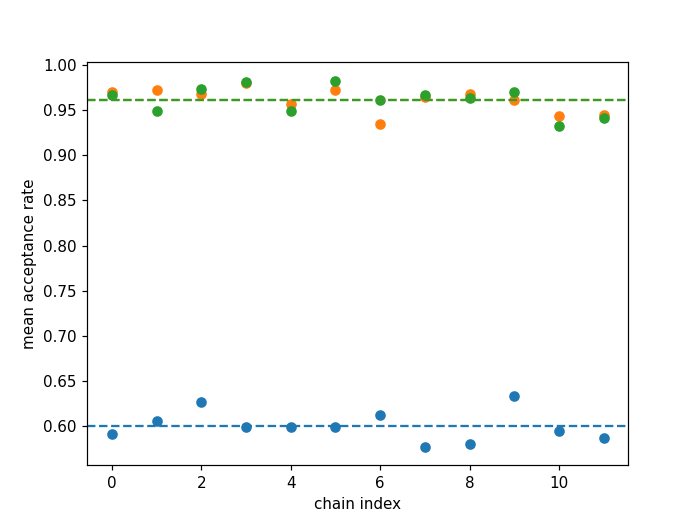

In [26]:
# plot
fig, ax = pyplot.subplots()
for tk in range(ntemps):
    ax.scatter(range(nchains), arate[tk,:], label='temp {}'.format(tk))
    ax.axhline(arate[tk,:].mean(), color='C{}'.format(tk), linestyle='--')
ax.set_ylabel('mean acceptance rate')
ax.set_xlabel('chain index')
fig.show()

In [27]:
print("Average acceptance rate over all chains:", arate.mean(axis=1))

Average acceptance rate over all chains: [0.60083008 0.9609375  0.96110026]


The ideal acceptance rate is ~0.23. We see here that we have a larger rate. This is not too surprising, since we only used a `Normal` proposal distribution with a variance of 1, whereas the sampled distribution had a variance of 2 in the y parameter. To get a rate closer to 0.23, we can use an `AdaptiveNormal` proposal distribution. See the `test_adaptive_normal.ipynb` notebook for more.

Let's also plot the average acceptance ratio. This should be approximately the same as the acceptance rate.

<IPython.core.display.Javascript object>


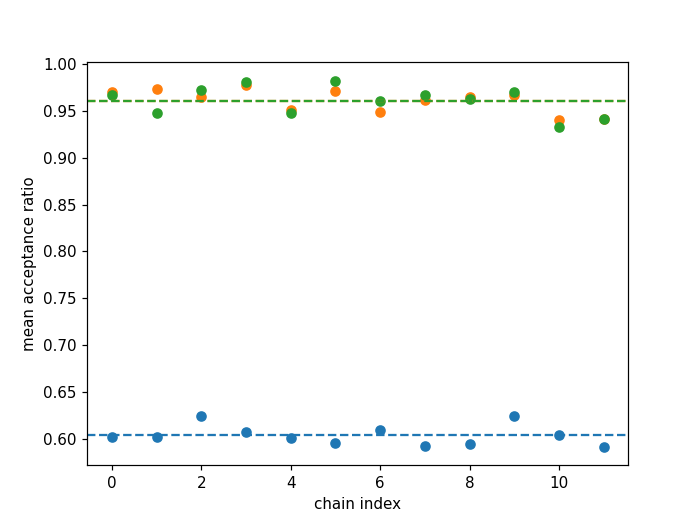

In [28]:
# plot
fig, ax = pyplot.subplots()
for tk in range(ntemps):
    ax.scatter(range(nchains), aratio[tk,:], label='temp {}'.format(tk))
    ax.axhline(aratio[tk,:].mean(), color='C{}'.format(tk), linestyle='--')
ax.set_ylabel('mean acceptance ratio')
ax.set_xlabel('chain index')
fig.show()

In [29]:
print("Average acceptance ratio over all chains:", aratio.mean(axis=1))

Average acceptance ratio over all chains: [0.60389344 0.9610056  0.9610353 ]


## Plot temperature swaps

Information about the temperature swaps is stored by the `temperature_acceptance` and `temperature_swaps` arrays. The former gives the acceptance ratio that was used to determine whether or not to swap the positions of the temperatures; it has shape `ntemps-1 x nchains x (niterations/swap_interval)` (the first dimension is `ntemps-1` because the acceptance ratio invovles two temperatures). The latter gives the indices of the chains that were swapped; it has shape `ntemps x nchains x (niterations/swap_interval)`.

For example, say `ntemps = 3` and the `swap_index` for one of the chains and iteration was:

`[2, 0, 1]`

This means that the position of the hottest chain (= 2) was swapped all the way down to the coldest chain (= 0), bumping up the colder positions; i.e., $\mathbf{x}_2 \rightarrow \mathbf{x}_0$; $\mathbf{x}_0 \rightarrow \mathbf{x}_1$; $\mathbf{x}_1 \rightarrow \mathbf{x}_2$. Likewise, a swap index `[0,2,1]` means $\mathbf{x}_2 \leftrightarrow \mathbf{x}_1$ while $\mathbf{x}_0$ remained in place, and `[1,0,2]` means that $\mathbf{x}_1 \leftrightarrow \mathbf{x}_0$, while $\mathbf{x}_2$ remained in place.

Note that you will never see a swap index like `[2,1,0]` or `[1,2,0]`; i.e., `0` will always be in either the first or second slot. This is because the swaps always progress from the hottest chain down to the coldest. So while a hotter position may move down more than one level in single swap, a colder position may at most only ever move up one level.

In [30]:
# get the swap indices and acceptance ratios; note that these are not
# structured arrays, and they have shape, niterations // swap interval
temperature_swaps = sampler.temperature_swaps
temperature_acceptance = sampler.temperature_acceptance
print('number of iterations:', sampler.niterations)
print('sampler.temperature_swaps.shape:', temperature_swaps.shape)
print('sampler.temperature_acceptance.shape:', temperature_acceptance.shape)

number of iterations: 1024
sampler.temperature_swaps.shape: (3, 12, 256)
sampler.temperature_acceptance.shape: (2, 12, 256)


<IPython.core.display.Javascript object>


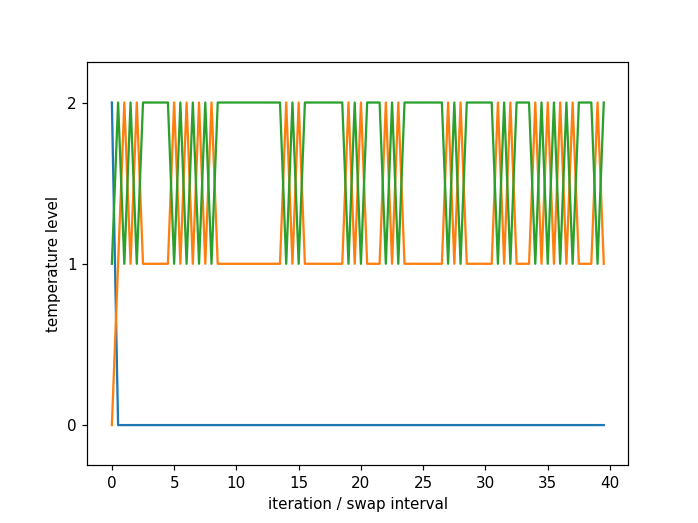

In [31]:
# we'll plot the swap index of the first chain;
swap_index = temperature_swaps[:, 0, :]
fig, ax = pyplot.subplots()
# we'll just plot the first 40 iterations
pltiters = 40
x = numpy.array([[ii, ii+0.5] for ii in range(pltiters)]).flatten()
for tk in range(sampler.ntemps):
    y = numpy.array([[swap_index[tk, ii], tk] for ii in range(pltiters)]).flatten()
    ax.plot(x, y, color='C{}'.format(tk))
#ax.legend()
ax.set_ylim(-0.25, 2.25)
ax.set_yticks([0, 1, 2])
ax.set_xlabel('iteration / swap interval')
ax.set_ylabel('temperature level')
fig.show()

We see that the first and second level are swapping on nearly every iteration, but coldest barely swaps at all. This suggests that our temperature ladder spacing was too large. Let's check the acceptance ratios.

<IPython.core.display.Javascript object>


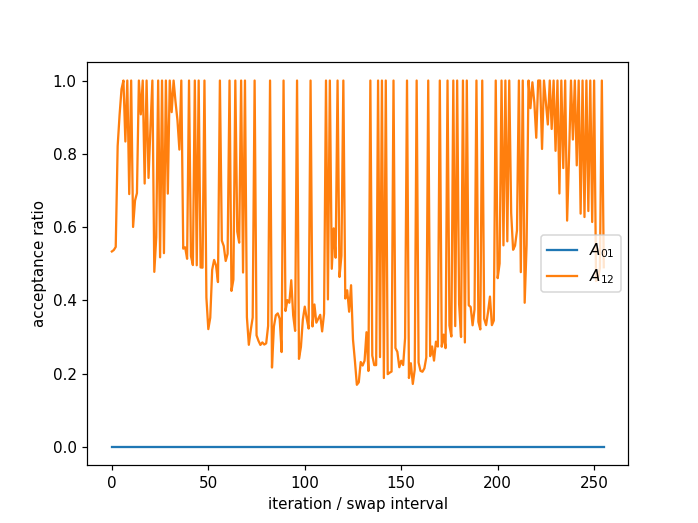

In [32]:
temp_acceptance_ratio = sampler.temperature_acceptance
fig, ax = pyplot.subplots()
for tk in range(sampler.ntemps-1):
    # cap acceptance ratio at 1
    ar = temp_acceptance_ratio[tk, 1, :].copy()
    ar[ar > 1] = 1.
    ax.plot(ar, label='$A_{%i %i}$'%(tk, tk+1))
ax.legend()
ax.set_xlabel('iteration / swap interval')
ax.set_ylabel('acceptance ratio')
fig.show()

## Plot the posterior
Let's create a scatter plot of the posterior. For this, we'll need to throw out some earlier samples for the burn-in period; we'll just assume the first-half of the chains were burn in. We also need to calculate the autocorrelation length of the chains in order to get independent samples.

In [33]:
def calculate_acf(data):
    """Calculates the autocorrelation of some data"""
    # zero the mean
    data = data - data.mean()
    # zero-pad to 2 * nearest power of 2
    newlen = int(2**(1+numpy.ceil(numpy.log2(len(data)))))
    x = numpy.zeros(newlen)
    x[:len(data)] = data[:]
    # correlate
    acf = numpy.correlate(x, x, mode='full')
    # drop corrupted region
    acf = acf[len(acf)//2:]
    # normalize
    acf /= acf[0]
    return acf

def calculate_acl(data):
    """Calculates the autocorrelation length of some data.
    
    Algorithm used is from:
    N. Madras and A.D. Sokal, J. Stat. Phys. 50, 109 (1988).
    """
    # calculate the acf
    acf = calculate_acf(data)
    # now the ACL: Following from Sokal, this is estimated
    # as the first point where M*tau[k] <= k, where
    # tau = 2*cumsum(acf) - 1, and M is a tuneable parameter,
    # generally chosen to be = 5 (which we use here)
    m = 5
    cacf = 2.*numpy.cumsum(acf) - 1.
    win = m * cacf <= numpy.arange(len(cacf))
    if win.any():
        acl = int(numpy.ceil(cacf[numpy.where(win)[0][0]]))
    else:
        # data is too short to estimate the ACL, just choose
        # the length of the data
        acl = len(data)
    return acl

For parallel tempered chains, we take the ACL for a given chain as the maximum ACL over all of the temperatures of that chain. Usually, the longest ACL comes from the coldest chain (from which we get the posterior). Since the chains are completely independent of each other, we can calculate the ACL separately for each chain. However, if you'd like to be more conservative, you can also just take the max over all of the chains.

In [34]:
# get the samples; recall that this is a dictionary of 
# nchains x niterations arrays for each parameter
samples = sampler.positions
# as we said above, we'll assume the first half
# of the chain was burn in
burnin_iter = sampler.niterations // 2
# set up arrays to store the ACL of each chain and
# the thinned chains
acls = numpy.zeros(nchains, dtype=int)
# cycle over the chains, calculating the ACLs and thinning them
for ii in range(nchains):
    temp_acls = numpy.zeros(ntemps, dtype=int)
    for tk in range(ntemps):
        # get the second half of the chains
        sx = samples['x'][tk, ii, burnin_iter:]
        sy = samples['y'][tk, ii, burnin_iter:]
        # compute the acl for each parameter
        aclx = calculate_acl(sx)
        acly = calculate_acl(sy)
        acl = max(aclx, acly)
        temp_acls[tk] = acl
    # take the max over the temps
    acl = max(temp_acls)
    acls[ii] = acl
# thin the arrays
thinned_arrays = {'x': [], 'y': []}
for tk in range(ntemps):
    txarray = []
    tyarray = []
    for ii in range(nchains):
        sx = samples['x'][tk, ii, burnin_iter:]
        sy = samples['y'][tk, ii, burnin_iter:]
        # we'll thin the arrays starting from the
        # end to get the lastest results
        txarray.append(sx[::-1][::acls[ii]][::-1])
        tyarray.append(sy[::-1][::acls[ii]][::-1])
    thinned_arrays['x'].append(txarray)
    thinned_arrays['y'].append(tyarray)

In [35]:
# the ACL of each chain:
print(acls)

[45 49 24 61 57  8 67 55 54 54 50 39]


In [36]:
# create a flattened posterior array from the coldest temperature
posterior = {'x': numpy.concatenate(thinned_arrays['x'][0]),
             'y': numpy.concatenate(thinned_arrays['y'][0])}
print("Number of independent samples:", posterior['x'].size)

Number of independent samples: 190


<IPython.core.display.Javascript object>


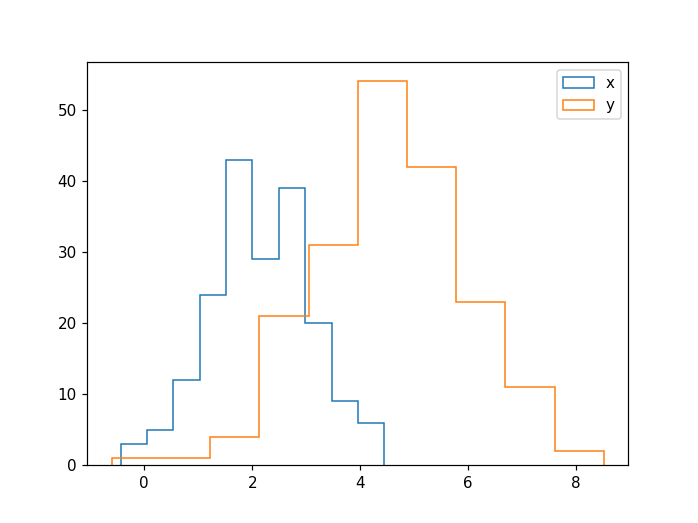

In [37]:
# histogram them
fig, ax = pyplot.subplots()
ax.hist(posterior['x'], bins=10, histtype='step', label='x')
ax.hist(posterior['y'], bins=10, histtype='step', label='y')
ax.legend()
fig.show()

Let's check the mean and variance of our estimated posterior. These should be $\bar{x} \approx 2, \sigma^2_{x} \approx 1$ and $\bar{y} \approx 5, \sigma^2_{y} \approx 2$:

In [38]:
for param in posterior:
    s = posterior[param]
    print(param, 'mean: {}'.format(s.mean()), 'var: {}'.format(s.var()))

x mean: 2.162324339697947 var: 0.9164116799516882
y mean: 4.572372068020173 var: 2.004351768371903


## Create an animation of the results

To visualize the results, we'll create an animation showing how the chains evolved. We'll do this by plotting one point for each chain, with each frame in the animation representing a single iteration.

***Note: To keep file size down, the animation has not been created for the version of this notebook uploaded to the repository.***

In [ ]:
from matplotlib import animation

In [ ]:
# Prepare an array to create a density map showing the shape of the model posterior
npts = 100
xmean, ymean = model.likelihood_dist.mean
xsig = model.likelihood_dist.cov[0,0]**0.5
ysig = model.likelihood_dist.cov[1,1]**0.5
X, Y = numpy.mgrid[xmean-3*xsig:xmean+3*xsig:complex(0, npts),
                   ymean-3*ysig:ymean+3*ysig:complex(0, npts)]
Z = numpy.zeros(X.shape)
for ii in range(Z.shape[0]):
    for jj in range(Z.shape[1]):
        logl, logp = model(x=X[ii,jj], y=Y[ii,jj])
        Z[ii, jj] = numpy.exp(logl+logp)

In [ ]:
# we'll just animate the first 200 iterations; change this to
# nframes = xdata.shape[1] if you want to see all iterations
nframes = 200

In [ ]:
fig, ax = pyplot.subplots()

positions = sampler.positions[0,...]
xdata = positions['x']
ydata = positions['y']

# Plot contours showing the shape of the true posterior density
#ax.contour(X, Y, Z, 2, colors='k', linewidths=1, linestyles='dashed', zorder=-2)
ax.imshow(numpy.rot90(Z), extent=[X.min(), X.max(), Y.min(), Y.max()],
          aspect='auto', cmap='binary', zorder=-3)

# Put an x at the maximum posterior point
ax.scatter(model.mean[0], model.mean[1], marker='x', color='w', s=10, zorder=-2)
ax.set_xlabel('x')
ax.set_ylabel('y')
# create the scatter points
ptsize = 60

# we'll include the last bufferlen number of steps a chain visited, having the size and transparency
# exponentially damped with each new frame
bufferlen = 16
alphas = numpy.exp(-4*(numpy.arange(bufferlen))/float(bufferlen))
sizes = ptsize * alphas
#colors = numpy.array(['C{}'.format(ii) for ii in range(nchains)])
colors = numpy.arange(nchains)
plts = [ax.scatter(xdata[:, bufferlen-ii-1], ydata[:, bufferlen-ii-1], c=colors, s=sizes[ii],
                   edgecolors='w', linewidths=0.5,
                   alpha=alphas[ii], zorder=bufferlen-ii, marker='s' if ii==0 else 'o', cmap='jet')
        for ii in range(bufferlen)]
# put a + showing the average of the chain positions at the current iteration
meanplt = ax.scatter(xdata[:,0].mean(), ydata[:,0].mean(), marker='P', c='w', edgecolors='k', linewidths=0.5,
                     zorder=bufferlen+1)

# add some text giving the iteration
itertxt = 'Iteration {}'
txt = ax.annotate(itertxt.format(1), (0.03, 0.94), xycoords='axes fraction')

def animate(ii):
    txt.set_text(itertxt.format(ii+1))
    for jj,plt in enumerate(plts):
        plt.set_offsets(numpy.array([xdata[:, max(ii-jj, 0)], ydata[:, max(ii-jj, 0)]]).T)
    meanplt.set_offsets([xdata[:,ii].mean(), ydata[:,ii].mean()])
    # zoom in as it narrows on the result
    istart = max(ii-bufferlen, 0)
    # smooth it out a bit
    xmin = numpy.array([xdata[:, max(istart-kk, 0):].min() for kk in range(50)]).mean()
    xmax = numpy.array([xdata[:, max(istart-kk, 0):].max() for kk in range(50)]).mean()
    ymin = numpy.array([ydata[:, max(istart-kk, 0):].min() for kk in range(50)]).mean()
    ymax = numpy.array([ydata[:, max(istart-kk, 0):].max() for kk in range(50)]).mean()
    ax.set_xlim((1.1 if xmin < 1 else 0.9)*xmin, (0.9 if xmax < 1 else 1.1)*xmax)
    ax.set_ylim((1.1 if ymin < 1 else 0.9)*ymin, (0.9 if ymax < 1 else 1.1)*ymax)


ani = animation.FuncAnimation(fig, animate, frames=nframes, interval=160, blit=True)

Save the animation:

In [ ]:
ani.save('pt_chain_animation.mp4')

The result:

In [ ]:
%%HTML
<video width="640" height="480" controls>
  <source src="pt_chain_animation.mp4" type="video/mp4">
</video>